In [1]:
import os
import numpy as np
import cv2
from IPython.display import display
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.preprocessing.image import array_to_img
import tensorflow as tf

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Set the path to the folder containing rose images
data_folder = './flowers/rose/'

# List all image file names in the folder
image_files = os.listdir(data_folder)

# Create empty lists to store images and labels
images = []
labels = []

# Read images and assign labels
for filename in image_files:
    if filename.endswith('.jpg'):  # Consider only JPG images
        img_path = os.path.join(data_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))  # Resize the images to a consistent size
        img = img / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
        labels.append(1)  # Assuming all images in this folder are roses

# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# For Siamese network, you need to create pairs of images
X_train_1 = X_train[y_train == 1]
X_train_2 = np.roll(X_train_1, shift=1, axis=0)  # Create pairs by shifting the images

# Note: For a more comprehensive dataset, you might want to consider negative pairs (non-matching images)
# Now you have X_train_1 and X_train_2 as pairs of rose images ready to be used for training



In [3]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

In [4]:
def siamese_network(input_shape):
    input_1 = Input(input_shape)
    input_2 = Input(input_shape)

    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
    ])

    encoded_1 = model(input_1)
    encoded_2 = model(input_2)

    distance = Lambda(euclidean_distance)([encoded_1, encoded_2])

    siamese_model = Model(inputs=[input_1, input_2], outputs=distance)
    return siamese_model

In [5]:
input_shape = (128, 128, 3)
siamese = siamese_network(input_shape)

# Compile the model with a contrastive loss function and optimizer

siamese.compile(loss='binary_crossentropy', optimizer='adam')

# Train the Siamese network with your prepared dataset

siamese.fit([X_train_1, X_train_2], y_train, batch_size=32, epochs=10)

Metal device set to: Apple M1 Pro


2023-08-17 10:11:05.329392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-17 10:11:05.329536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-08-17 10:11:05.598599: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-17 10:11:05.793102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 118ms/step - loss: 0.0010
Epoch 2/10
20/20 [==============================] - 2s 106ms/step - loss: 0.0000e+00
Epoch 3/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00
Epoch 4/10
20/20 [==============================] - 2s 106ms/step - loss: 0.0000e+00
Epoch 5/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00
Epoch 6/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00
Epoch 7/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00
Epoch 8/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00
Epoch 9/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00
Epoch 10/10
20/20 [==============================] - 2s 105ms/step - loss: 0.0000e+00


1/1 [==============================] - 0s 15ms/step


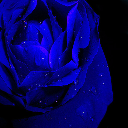

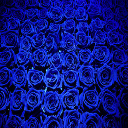

Percentage Similarity: [-48726.96]


In [8]:
# Load and preprocess image_1
image_1_path = './flowers/rose/353897245_5453f35a8e.jpg'
image_1 = cv2.imread(image_1_path)
image_1 = cv2.resize(image_1, (128, 128))
image_1 = image_1 / 255.0  # Normalize pixel values

# Load and preprocess image_2
image_2_path = './flowers/rose/388405293_4db1d71f21_n.jpg'
image_2 = cv2.imread(image_2_path)
image_2 = cv2.resize(image_2, (128, 128))
image_2 = image_2 / 255.0  # Normalize pixel values

# Convert the individual images to pairs
image_pair = [image_1, image_2]

# Convert the image pair to a NumPy array
image_pair = np.array(image_pair)

# Calculate similarity between the image pair
similarity = siamese.predict([image_pair[0:1], image_pair[1:2]])

# Assuming 'similarity' is the output from the siamese.predict() function
similarity_score = similarity[0]  # Extract the similarity score from the array

# Convert similarity score to percentage similarity
percentage_similarity = (1 - similarity_score) * 100

# Convert the NumPy array to a PIL image
pil_image_1 = array_to_img(image_1)
pil_image_2 = array_to_img(image_2)

# Display the PIL image
display(pil_image_1)
display(pil_image_2)

print(f"Percentage Similarity:", percentage_similarity)